`conda activate CASM_TORCH2`

# Install torch if necessary. See https://pytorch.org/get-started/locally/
# pip install torch==1.11.0

# Install torch geometric if necessary. See: https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
# pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cpu.html


In [5]:
import sys
sys.path.append('../')

import logging
logging.getLogger('matplotlib').setLevel(logging.CRITICAL)
logging.getLogger('graphein').setLevel(logging.INFO)

In [6]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import pytorch_lightning as pl
from tqdm.notebook import tqdm
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score

import math
import glob

import warnings
warnings.filterwarnings("ignore")

/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from CASM.kin_sub_pairs import load_kin_sub_list
df = load_kin_sub_list(
    "../datasets/Kinase_Substrate_Dataset"
)
#print(df)

# Filter for only ``str`` rows
def filter_fn(row):
    if type(row['KIN_ACC_ID']) == str: 
        return True
    else: return False
    
df.apply(filter_fn, axis=1)

#y = torch.randn([5, 10])



0        True
1        True
2        True
3        True
4        True
         ... 
22347    True
22348    True
22349    True
22350    True
22351    True
Length: 22352, dtype: bool

In [8]:
npy_file = "../../DATA/PPI/npy_file_human_dataset.npy"
processed_dir = "../../DATA/processed"
npy_ar = np.load(npy_file)

print(npy_ar.shape)

from torch.utils.data import Dataset as Dataset_n
from torch_geometric.data import DataLoader as DataLoader_n

class LabelledDataset(Dataset_n):
    def __init__(self, npy_file, processed_dir):
      self.npy_ar = np.load(npy_file)
      self.processed_dir = processed_dir
      self.protein_1 = self.npy_ar[:,2]
      self.protein_2 = self.npy_ar[:,5]
      self.label = self.npy_ar[:,6].astype(float)
      self.n_samples = self.npy_ar.shape[0]

      print(f"P1: {self.protein_1[0:10]}")

    def __len__(self):
      return(self.n_samples)

    def __getitem__(self, index):
      prot_1 = os.path.join(self.processed_dir, self.protein_1[index]+".pt")
      prot_2 = os.path.join(self.processed_dir, self.protein_2[index]+".pt")
      #print(f'Second prot is {prot_2}')
      prot_1 = torch.load(glob.glob(prot_1)[0])
      #print(f'Here lies {glob.glob(prot_2)}')
      prot_2 = torch.load(glob.glob(prot_2)[0])
      return prot_1, prot_2, torch.tensor(self.label[index])


dataset = LabelledDataset(npy_file = npy_file ,processed_dir= processed_dir)

print(dataset[0])

final_pairs =  np.load(npy_file)
size = final_pairs.shape[0]

seed = 42
torch.manual_seed(seed)

trainset, testset = torch.utils.data.random_split(dataset, [math.floor(0.8 * size), size - math.floor(0.8 * size) ])


# Dataloaders
trainloader = DataLoader_n(dataset= trainset, batch_size= 4, num_workers = 0)
testloader = DataLoader_n(dataset= testset, batch_size= 4, num_workers = 0)
print("Length")
print(len(trainloader))
print(len(testloader))





(22217, 7)
P1: ['1FLK' '2JVX' '3ALN' '1J0W' '5FQD' '4EGC' '2CYX' '1CFH' '3UXG' '1P9C']
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_605425/506600144.py", line 36, in <cell line: 36>
    print(dataset[0])
  File "/tmp/ipykernel_605425/506600144.py", line 28, in __getitem__
    prot_1 = torch.load(glob.glob(prot_1)[0])
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/

In [9]:

import torch
from graphein.ml import ProteinGraphDataset
import graphein.protein as gp

To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install: biovec 
biovec cannot be installed via conda
To use the Graphein submodule graphein.protein.visualisation, you need to install: pytorch3d 
To do so, use the following command: conda install -c pytorch3d pytorch3d


[11/12/22 16:56:00] WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=845615;file:///home/cim/STRUCTURAL_MOTIFS/CASM/CASM/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=347858;file:///home/cim/STRUCTURAL_MOTIFS/CASM/CASM/graphein/protein/meshes.py#29\29]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: conda install -c pytorch3d pytorch3d             

In [10]:
"""
Kinase dataset
"""

npy_file = "../CASM/alphafold_structures" # TODO:SAVED ARRAY OF INTERACTING PROTEIN PAIRS
processed_dir = "../../"
npy_ar = np.load(npy_file)


print(npy_ar.shape)

from torch.utils.data import Dataset 
from torch_geometric.data import DataLoader 

class KinaseInteractionDataset(Dataset):
    def __init__(self, npy_file, processed_dir):

      # TODO
      self.npy_ar = np.load(npy_file)
      self.processed_dir = processed_dir
      self.kinase = self.npy_ar[:,2]
      self.substrate = self.npy_ar[:,5]

      self.mod_rsd = self.npy_ar[:,6]

      self.label = self.npy_ar[:,6].astype(float)
      self.n_samples = self.npy_ar.shape[0]

      print(f"kinase: {self.kinase[0:10]}")

    def __len__(self):
      return(self.n_samples)

    def __getitem__(self, index):
      

      kinase = os.path.join(self.processed_dir, self.kinase[index]+".pt")
      site = os.path.join(self.processed_dir, self.substrate[index] + "-" + self.mod_rsd[index] + ".pt") # Filenames are {acc_id}-{mod_rsd}.pt


      kinase = torch.load(glob.glob(kinase)[0])

      psite = torch.load(glob.glob(psite)[0])

      return kinase, psite, mod_rsd, torch.tensor(self.label[index])

      # TODO: alternative to keeping labels stored:  in __getitem__ , we lookup from another source whether or not 
      # the two things interact (i.e. which label); since this will change based on how we create negative examples etc. 
      # so we should abstract away into a function that returns what the label is
      # this means we don't regenerate the .npy array everytime we modify our dataset

dataset = KinaseInteractionDataset(npy_file=npy_file ,processed_dir=processed_dir)

print(dataset[0])

final_pairs =  np.load(npy_file)
size = final_pairs.shape[0]

seed = 42
torch.manual_seed(seed)

trainset, testset = torch.utils.data.random_split(dataset, [math.floor(0.8 * size), size - math.floor(0.8 * size) ])


# Dataloaders
trainloader = DataLoader(dataset=trainset, batch_size=4, num_workers = 0)
testloader = DataLoader(dataset=testset, batch_size=4, num_workers = 0)
print("Length")
print(len(trainloader))
print(len(testloader))


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_605425/2429386212.py", line 7, in <cell line: 7>
    npy_ar = np.load(npy_file)
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/numpy/lib/npyio.py", line 390, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: '../CASM/alphafold_structures'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import pathlib
import math
import sklearn
#import torch_optimizer as optim
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#from metrics import *



for count, (p1, p2, label) in enumerate(trainloader):

    print(label)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_605425/2162167709.py", line 16, in <cell line: 16>
    for count, (p1, p2, label) in enumerate(trainloader):
NameError: name 'trainloader' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1012, in structured_trac

In [12]:
import torch

In [13]:
import numpy as np

graph_path = "../GRAPHS2/processed/O13016.pt"

os.path.exists(graph_path)

g = torch.load(graph_path)
g
# #hot = g.amino_acid_one_hot
# #g

# exit(1)

# t = torch.as_tensor(np.array(g.amino_acid_one_hot))
# type(t)
# type(np.array(g.psi))
# t

# a = torch.as_tensor([1, 0, 0, 0])

# #a.resize_(4, 1)
# print(a.shape == torch.Size([4]))
# a = a.view(-1, 1)
# #torch.transpose(a, 1, 0)
# print(a.shape)
# a.dtype

Data(edge_index=[2, 762], node_id=[434], coords=[1], b_factor=[434], amino_acid_one_hot=[434], esm_embedding=[434], asa=[434], num_nodes=434)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>

In [15]:
import glob 
import re

processed_dir = "../GRAPHS1/processed/"

kin_filenames = glob.glob("KIN_*", root_dir=processed_dir)

kin_ids = []
for k in kin_filenames:
    m = re.search(r'KIN_(.*?).pt', k)
    kin_ids.append(m.group(1))

kin_ids

['Q9NWZ3',
 'P16234',
 'Q92630',
 'P32298',
 'P06213',
 'Q32MK0',
 'Q15831',
 'O95747',
 'P48729',
 'P54756',
 'P29317',
 'Q08881',
 'Q9BZL6',
 'P17612',
 'Q9UF33',
 'P45985',
 'O75116',
 'Q06418',
 'O43353',
 'Q96KB5',
 'P09769',
 'Q8IV63',
 'O95835',
 'Q9NZJ5',
 'P15056',
 'O94806',
 'P51956',
 'Q9UGJ0',
 'Q5TCX8',
 'Q7KZI7',
 'Q07912',
 'Q13131',
 'Q6P3R8',
 'P09619',
 'Q8TD08',
 'P51955',
 'P00533',
 'Q02750',
 'Q96GD4',
 'O00238',
 'Q13043',
 'P45983',
 'O96013',
 'O14936',
 'Q9P1W9',
 'Q8N5S9',
 'Q9Y2U5',
 'Q9UK32',
 'Q9NSY1',
 'P27448',
 'Q3MIX3',
 'P19784',
 'O94921',
 'O00443',
 'Q8TDX7',
 'P05129',
 'P50750',
 'P07949',
 'Q8IVH8',
 'P54764',
 'P11021',
 'Q15375',
 'P35968',
 'P36507',
 'P24941',
 'P43405',
 'P36888',
 'Q13177',
 'P30530',
 'Q96QP1',
 'P08631',
 'P11802',
 'Q8IYT8',
 'P42680',
 'Q16513',
 'Q05513',
 'O00141',
 'Q16659',
 'Q96GX5',
 'P42345',
 'P53779',
 'P45984',
 'Q9H2G2',
 'Q15759',
 'Q13188',
 'P50613',
 'Q9UBE8',
 'Q9Y572',
 'P52564',
 'P48730',
 'Q13555',

In [16]:
import plotly.express as px

fig = px.imshow([[1, 20, 30],
                 [20, 1, 60],
                 [30, 60, 1]])
fig.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_605425/527939474.py", line 6, in <cell line: 6>
    fig.show()
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/plotly/basedatatypes.py", line 3398, in show
    return pio.show(self, *args, **kwargs)
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/plotly/io/_renderers.py", line 396, in show
    raise ValueError(
ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/cim

In [17]:
import numpy as np
import torch 

idx = [5, 20, 43, 59]

node_id = [['A:PRO:697', 'A:ALA:747', 'A:LEU:704', 'A:LEU:702', 'A:GLU:696', 'A:SER:700', 'A:PRO:693', 'A:GLN:750', 'A:LEU:751', 'A:ARG:699', 'A:LEU:695', 'A:VAL:698', 'A:ARG:703', 'A:LEU:705', 'A:SER:701'], ['A:LEU:229', 'A:ALA:205', 'A:ARG:228', 'A:ARG:235', 'A:CYS:239', 'A:SER:234', 'A:LEU:244', 'A:CYS:243', 'A:PHE:232', 'A:LYS:238', 'A:ASP:240', 'A:PRO:241', 'A:MET:202', 'A:VAL:236', 'A:LEU:233', 'A:SER:201', 'A:ARG:231', 'A:ILE:237', 'A:ASP:242', 'A:ARG:245', 'A:GLY:206', 'A:THR:230'], ['A:LEU:758', 'A:ASP:761', 'A:GLN:776', 'A:ARG:772', 'A:GLU:769', 'A:LYS:760', 'A:TYR:774', 'A:LEU:763', 'A:GLY:770', 'A:ARG:764', 'A:VAL:779', 'A:ILE:777', 'A:ASN:759', 'A:ALA:771', 'A:THR:778', 'A:SER:775', 'A:GLN:780', 'A:GLU:762', 'A:PHE:756', 'A:VAL:773', 'A:LEU:755'], ['A:ARG:48', 'A:SER:53', 'A:LYS:50', 'A:THR:51', 'A:MET:52', 'A:TRP:49', 'A:LYS:55', 'A:GLU:56', 'A:LYS:57', 'A:GLY:58', 'A:ALA:54']]

n = []
for i in node_id:
    n += i 

n = np.asarray(n)
n = n.flatten()

for i in idx:
    print(n[i])



A:SER:700
A:SER:234
A:TYR:774
A:SER:53


In [22]:
"""Graphein dataset download method"""

"""ALL IMPORTS """

import sys 

from graphein.protein.config import ProteinGraphConfig
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import pytorch_lightning as pl
from tqdm.notebook import tqdm
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score

import math
import glob

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn.functional as F

from torch_geometric.data import Batch, Data

from graphein.ml import ProteinGraphDataset

from CASM.kinase_dataset import KinaseSubstrateDataset

from graphein.ml.conversion import GraphFormatConvertor
import graphein.protein as gp

from graphein.protein.config import DSSPConfig
from graphein.protein.subgraphs import extract_surface_subgraph
from graphein.protein.features.nodes import rsa

from graphein.protein.features.sequence.embeddings import esm_sequence_embedding #, biovec_sequence_embedding

from graphein.protein.edges.distance import *

from graphein.protein.features.nodes.dssp import asa, phi, psi # Node metadata adding functions

from functools import partial
from graphein.protein.edges.distance import add_distance_threshold



In [19]:


# Try loading 



"""
Node features
"""
from graphein.protein.features.nodes.amino_acid import meiler_embedding, amino_acid_one_hot

from graphein.protein.graphs import construct_graph
config = ProteinGraphConfig(
    graph_metadata_functions=[esm_sequence_embedding],
)
g = construct_graph(config=config, pdb_code="3eiy")
em = g.graph["esm_embedding_A"]

len(g.nodes())
em[0]

Using cache found in /home/cim/.cache/torch/hub/facebookresearch_esm_main


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_605425/2678836061.py", line 14, in <cell line: 14>
    g = construct_graph(config=config, pdb_code="3eiy")
  File "/home/cim/STRUCTURAL_MOTIFS/CASM/CASM/graphein/protein/graphs.py", line 741, in construct_graph
    g = annotate_graph_metadata(g, config.graph_metadata_functions)
  File "/home/cim/STRUCTURAL_MOTIFS/CASM/CASM/graphein/utils/utils.py", line 69, in annotate_graph_metadata
    func(G)
  File "/home/cim/STRUCTURAL_MOTIFS/CASM/CASM/graphein/protein/features/sequence/embeddings.py", line 212, in esm_sequence_embedding
    G = compute_feature_over_chains(G, func, feature_name="esm_embedding")
  File "/home/cim/STRUCTURAL_MOTIFS/CASM/CASM/graphein/protein/features/sequence/utils.py", line 29, in compute_feature_over_chains
    G.graph[f"{fe

In [ ]:


# Try loading 



"""
Node features
"""
from graphein.protein.features.nodes.amino_acid import meiler_embedding, amino_acid_one_hot

from graphein.protein.graphs import construct_graph
config = ProteinGraphConfig()
g = construct_graph(config=config, pdb_code="3eiy")

g = su

In [ ]:
model_path = "../saved_models/GCN_TO_TEST_EMBEDDINGS.pth"


In [ ]:
# Kinase / substrate structure model 
processed_dir = "../GRAPHS1/processed/" 

ids = ["SUB_O14744_Y297.pt", "SUB_O00170_S43.pt"]
datalist = [torch.load(os.path.join(processed_dir, i)) for i in ids]
phosphosite: Batch = Batch.from_data_list(datalist)
print(phosphosite)
phi, psi = phosphosite.phi[0], phosphosite.psi[0]

def normalise_bond_angle(angles: list):
    return [(i + 180) / 360 for i in angles]

phi = normalise_bond_angle(phi) 
psi = normalise_bond_angle(psi)

psi


DataBatch(edge_index=[2, 45], node_id=[2], coords=[2], amino_acid_one_hot=[2], asa=[2], phi=[2], psi=[2], num_nodes=35, batch=[35], ptr=[3])


[0.8483333333333333,
 0.48777777777777775,
 0.4475,
 0.37666666666666665,
 0.38,
 0.3972222222222222,
 0.38472222222222224,
 0.8638888888888889,
 0.8994444444444445,
 0.4802777777777778,
 0.9294444444444445,
 0.3958333333333333,
 0.7755555555555556,
 0.8377777777777778,
 0.885,
 0.976111111111111,
 0.49250000000000005]

In [ ]:
processed_dir = "../GRAPHS3_MEILER/processed/"

ids = ["Q9CX34.pt", "O75376.pt"]

datalist = [torch.load(os.path.join(processed_dir, i)) for i in ids]




phosphosite: Batch = Batch.from_data_list(datalist)
print(phosphosite.meiler[0])
num_nodes = phosphosite.num_nodes
residue_encoding = phosphosite.meiler 
features = [residue_encoding, phosphosite.asa, phosphosite.b_factor]   # , pro2_data.asa, pro2_data.phi, pro2_data.psi]
                
# Concatenate along 1st dim (dim=0) to get all nodes for all batches in one tensor
for i, f in enumerate(features):
        
    features[i] = torch.as_tensor(np.concatenate([np.array(i, dtype=np.float32) for i in f]))
    f = features[i]
    # Vertically stack if only one feature long
    if f.shape == torch.Size([num_nodes]):
        features[i] = f.view(-1, 1)

# Concatenate all features together
x = torch.cat(features, dim=1)
x = x.float()
x[0]

#type(torch.tensor(g.meiler))
#e = list(g.esm_embedding[0])
# e = list(g.meiler[0])
# len(e)

# m = nn.Softmax(dim=1)
# ms = nn.Sigmoid(dim=1)

# input = torch.randn(4, 20)
# ms(input)




# output = m(input)
# sum(output[0])

[dim_1    2.35
dim_2    0.22
dim_3    4.43
dim_4    1.23
dim_5    5.71
dim_6    0.38
dim_7    0.32
Name: MET, dtype: float64, dim_1    1.28
dim_2    0.05
dim_3    1.00
dim_4    0.31
dim_5    6.11
dim_6    0.42
dim_7    0.23
Name: ALA, dtype: float64, dim_1    1.28
dim_2    0.05
dim_3    1.00
dim_4    0.31
dim_5    6.11
dim_6    0.42
dim_7    0.23
Name: ALA, dtype: float64, dim_1    1.28
dim_2    0.05
dim_3    1.00
dim_4    0.31
dim_5    6.11
dim_6    0.42
dim_7    0.23
Name: ALA, dtype: float64, dim_1    1.28
dim_2    0.05
dim_3    1.00
dim_4    0.31
dim_5    6.11
dim_6    0.42
dim_7    0.23
Name: ALA, dtype: float64, dim_1    1.28
dim_2    0.05
dim_3    1.00
dim_4    0.31
dim_5    6.11
dim_6    0.42
dim_7    0.23
Name: ALA, dtype: float64, dim_1    0.00
dim_2    0.00
dim_3    0.00
dim_4    0.00
dim_5    6.07
dim_6    0.13
dim_7    0.15
Name: GLY, dtype: float64, dim_1    2.67
dim_2    0.00
dim_3    2.72
dim_4    0.72
dim_5    6.80
dim_6    0.13
dim_7    0.34
Name: PRO, dtype: float64,

tensor([2.3500e+00, 2.2000e-01, 4.4300e+00, 1.2300e+00, 5.7100e+00, 3.8000e-01,
        3.2000e-01, 2.4900e+02, 3.9020e+01])

In [ ]:
idx = 4 
idx = 10 
from CASM.load_dbPTM import NUM_KINASE_FAMILIES, KINASE_TO_INDEX, KINASE_FAMILIES


#F.one_hot(, num_classes=NUM_KINASE_FAMILIES)
def get_1hot_kinase(k: str):
    if k not in KINASE_TO_INDEX:
        raise KeyError(f"'{k}' not a kinase family")

    idx = KINASE_TO_INDEX[k]
    return F.one_hot(torch.tensor(idx), num_classes=NUM_KINASE_FAMILIES)

k = "GRK"
get_1hot_kinase(k)



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])

In [ ]:
F.one_hot(torch.tensor(24), num_classes=NUM_KINASE_FAMILIES)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1])

In [ ]:
# Get hit @ 1, hit @ 3 etc. accuracy 

# imagine 4 batches of predictions, each with 6 classes

# Given batch of predictions, and batch of labels: returns accuracy 
def hit_at_n_accuracy():
    pass 
    # TODO

"""
Returns true if (any) true kinase is in top N classes
"""
def hit_at_n(
    prediction, 
    true_kinases,  # Should be list of lists; for batch_size 
    n: int = 1, 
):
    num_hits = 0
    indexes = torch.topk(prediction, n).indices

    for i, idx in enumerate(indexes):
        
        for j in idx:
            j = int(j)
            kin = KINASE_FAMILIES[j]
            #print(f"kin: {kin}")
            if kin in true_kinases[i]:
                
                #print("yes!")
                #return True
                num_hits += 1

    return num_hits


batch_size  = 10^5
N           = 5

a = torch.randn(batch_size, NUM_KINASE_FAMILIES)
#print(a)
true_kinases = [["CDK", "CAMK2"], ["PKG"], ["PKG"], ["PKG", "CAMK2"]] # "Correct", if ANY of these are predicted in top N classes
true_kinases = [["CDK", "CAMK2"]] * batch_size

true_kinases = [["PKN"]] * batch_size
#true_kinases = [["PKN", "CAMK2", "CDK"]] * batch_size
num_correct = hit_at_n(a, true_kinases, n=N)

accuracy = num_correct / batch_size
accuracy

0.2

In [21]:
def cross_entropy(input, target):

    return torch.mean(-torch.sum(target * torch.log(input), dim=1))
    

x = torch.tensor(
    [
        [0.2, 0.2, 0.6],
        [0.5, 0, 0.5],
        [0.2, 0.2, 0.6],
    ]
)
y = torch.tensor(
    [
        [0.3, 0.1, 0.6],
        [0.51, 0, 0.49],
        [0.2, 0.2, 0.6],
    ]   
)

criterion = torch.nn.CrossEntropyLoss()
loss = criterion(x, y)
y_ = cross_entropy(x, y)
print(loss, y_)

tensor(0.9930) tensor(nan)


In [ ]:
y = torch.tensor(
    [
        [0.3, 0.1, 0.6],
        [0.51, 0, 0.49],
        [0.2, 0.2, 0.6],
    ]   
)

x = torch.tensor([10, 30, 100]).float()
F.normalize(x, p=2, dim=0)

tensor([0.0953, 0.2860, 0.9535])

In [ ]:
input = torch.randn(3, 2, requires_grad=True)
target = torch.rand(3, 2, requires_grad=False)
[[0], [1], [1], [1]]
[[1], [1], [1], [0.9]]

a = [.5, .5, .5, .5]
a = [[.5]] * 4 

 
b = [1, 1, 1, 1]
b = [[1]] * 4
target = torch.tensor([1]).float()
input = torch.tensor([.5]).float()

loss = F.binary_cross_entropy(input, target)

print(input)
print(target)
print(loss)
#loss.backward()

b = [[1]] * 4
target = torch.tensor([b]).float()
torch.flatten(target)

tensor([0.5000])
tensor([1.])
tensor(0.6931)


tensor([1., 1., 1., 1.])

In [ ]:
input = torch.randn(3, 2, requires_grad=True)
target = torch.rand(3, 2, requires_grad=False)
loss = F.binary_cross_entropy(torch.sigmoid(input), target)
print(target, input)
loss

tensor([[0.2088, 0.6627],
        [0.0701, 0.2490],
        [0.2734, 0.9697]]) tensor([[-2.0024, -0.3564],
        [-0.8676,  0.1215],
        [ 0.4703,  1.4270]], requires_grad=True)


tensor(0.5890, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
a = torch.tensor([[0.5274, 0.5248, 0.5332, 0.5251]]).float()
b = torch.tensor([[1, 1, 0, 1]]).float()
loss = F.binary_cross_entropy(a, b)
loss

tensor(0.6726)

In [ ]:
label = torch.tensor([[1],
        [0],
        [1],
        [1]])

output = torch.tensor([[0.5212],
        [0.5237],
        [0.5187],
        [0.5217]])

label
output
func = nn.CrossEntropyLoss()

##

loss = nn.CrossEntropyLoss() 
input = torch.randn(3, 5, requires_grad=True)

target = torch.empty(3, dtype=torch.long).random_(5)


input = torch.tensor([0, 0, 0, 1]).float()
target = torch.tensor([0, 0, 1, 0]).float()

print(target)
print(input)

output = loss(input, target)
output
# output.backward()
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()

tensor([0., 0., 1., 0.])
tensor([0., 0., 0., 1.])
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3374/3050540194.py", line 29, in <cell line: 29>
    output = loss(input, target)
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/torch/nn/modules/loss.py", line 1163, in forward
    return F.cross_entropy(input, target, weight=self.weight,
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/torch/nn/functional.py", line 2996, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
IndexError: Dimension out of range (expected to be in range of 

In [ ]:
kins = ["CDK", "CK2", "DYRK"]

length = len(KINASE_FAMILIES)
multihot = [0] * length
for i in range(length):
    if KINASE_FAMILIES[i] in kins:
        multihot[i] = 1 
    else:
        multihot[i] = 0

torch.tensor(multihot)





tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])

In [20]:
"""Plot model predictions (from .npy array of confidence values for all sub / kin pairs"""
"""TODO: use saved known examples to show 'error' heatmap; i.e. (model prediction - true val) (will be 0 if correct; will be negative val if false neg; pos if false pos"""
import seaborn as sns
title="Model predictions"



fig = sns.heatmap(
            dist_mat, xticklabels=tick_labels, yticklabels=tick_labels
        ).set(title=title)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_605425/3404022043.py", line 9, in <cell line: 8>
    dist_mat, xticklabels=tick_labels, yticklabels=tick_labels
NameError: name 'dist_mat' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/cim/anaconda3/envs/CASM_TORCH2/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1012, in structured_trac

In [82]:
from io import StringIO
import csv
import pandas as pd

fp = "meiler_values.csv"
with open(fp) as f:

    reader = csv.reader(f, delimiter=',')
names = ["ALA","ARG","ASN","ASP","CYS","GLN","GLU","GLY","HIS","ILE","LEU","LYS","MET","PHE","PRO","SER","THR","TRP","TYR","VAL"]

df = pd.read_csv(fp, delim_whitespace=False, names=names)
df['ALA'][1]
#print(df)
MEILER_MAX = 10.74
MEILER_MIN = -1.01

ar = df.to_numpy() 
ar = ar - MEILER_MIN
ar = ar / MEILER_MAX
ar




0.0

In [96]:
"""Visualise KINASE EMBEDDINGS from DeepKinZero"""

data_path = "../../DATA/DEEP_KIN_ZERO/"
KinaseEmbeddingPath = os.path.join(data_path, "KinaseFeatures.txt")

def readKinaseEmbedding():
        """
        Read the kinase embeddings file to get the features of kinases
        """
        
        with open(KinaseEmbeddingPath) as csvfile:
            KinEmb = csv.reader(csvfile, delimiter='\t')
            #next(KinEmb, None) # Pass the header
            families = []
            groups = []
            KinUniProtIDs = []
            EnzymesVecs = []
            Domains = []
            Kin2Vecs = []
            Pathways = []
            # Read the kinase embedding file
            for row in KinEmb:
                KinUniProtID = row[0]
                KinUniProtIDs.append(KinUniProtID)
                Family = row[1]
                families.append(Family)
                Group = row[2]
                groups.append(Group)
                EnzymesVec = row[3]
                EnzymesVec = list(EnzymesVec)
                EnzymesVec = list(map(int,EnzymesVec))
                EnzymesVecs.append(EnzymesVec)
                Domain = row[4]
                Domains.append(Domain)
                Kin2Vec = row[5]
                Kin2Vec = Kin2Vec.split(", ")
                Kin2Vec = list(map(float, Kin2Vec))
                Kin2Vecs.append(Kin2Vec)
                Pathway = row[6]
                Pathway = Pathway.split(", ")
                Pathway = list(map(int,map(float, Pathway)))
                Pathways.append(Pathway)

            return KinUniProtIDs, Kin2Vecs, families, groups
            # Create dictionary for each of the embeddings
            # self.Kinonehot_encoded, self.KinaseEncoder = self.makeonehotencoded(KinUniProtIDs) # Convert UniProtIDs to one-hot encoded
            # self.Familyonehot_encoded, self.familyEncoder = self.makeonehotencoded(families) # Convert families to one-hot encoded vectors
            # self.Grouponehot_encoded, self.groupEncoder = self.makeonehotencoded(groups) # Convert groups to one-hot encoded vectors
            # self.UniProtID_to_OneHotVec = dict(zip(KinUniProtIDs,self.Kinonehot_encoded))
            # self.UniProtID_to_FamilyVec= dict(zip(KinUniProtIDs,self.Familyonehot_encoded))
            # self.UniProtID_to_GroupVec= dict(zip(KinUniProtIDs,self.Grouponehot_encoded))
            # self.UniProtID_to_Kin2Vec= dict(zip(KinUniProtIDs, Kin2Vecs))
            # self.UniProtID_to_EnzymesVec = dict(zip(KinUniProtIDs, EnzymesVecs))
            # self.UniProtID_to_Pathway= dict(zip(KinUniProtIDs, Pathways))

In [110]:
""" 
MODEL 2
"""
from sklearn.manifold import TSNE
import seaborn as sns

uniprots, Kin2Vecs, families, groups = readKinaseEmbedding()

kins = np.array(Kin2Vecs)

#plot_tsne(kins, families)
len(kins)


458

[Text(0.5, 1.0, 'Phosphosite-kinase family association predictions')]

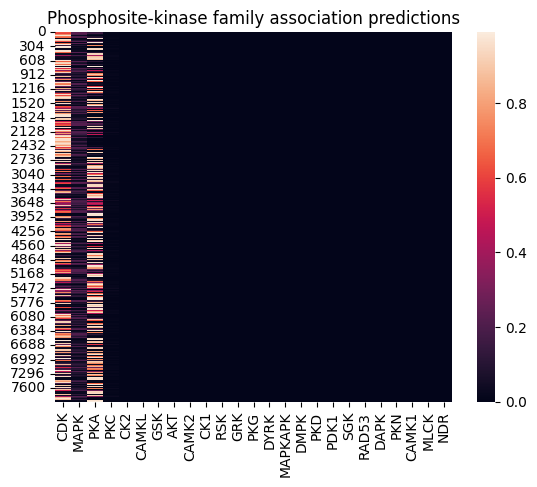

In [103]:
"""Visualise embeddings"""

""" 
MODEL 2
"""
from sklearn.manifold import TSNE
import seaborn as sns

from CASM.load_dbPTM import KINASE_FAMILIES

kinase_families = []
with open("kinase_family_labels_model2.txt") as f:
    for line in f:
        x = line[:-1]
        kinase_families.append(x)

def plot_tsne(em, labels):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

    results = tsne.fit_transform(em)

    n_labels = len(set(labels))
    print(f"{n_labels} labels")
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        #x="tsne-2d-one", y="tsne-2d-two",
        x=results[:,0], y=results[:,1],
        hue=labels,
        palette=sns.color_palette("viridis", n_labels),
        #data=results,
        legend="full",
        alpha=0.6
    )

# MODEL 1 
fp = "embeddings_m1_23.npy"  # AFTER CONV1
fp = "./embeddings_m1_fc1_relu_128.npy" # AFTER FC1, RELU 

# MODEL 2
fp = "./embeddings_m2_fc1_128.npy"

em = np.load(fp)

preds = np.load("./predictions_m2_run1.npy")

title = "Phosphosite-kinase family association predictions"
fig = sns.heatmap(
    preds,
    xticklabels=KINASE_FAMILIES,
    
).set(title=title)
fig
#print(em)
#plot_tsne(em, kinase_families)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 314 samples in 0.000s...
[t-SNE] Computed neighbors for 314 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 314 / 314
[t-SNE] Mean sigma: 14.900760
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.440022
[t-SNE] KL divergence after 300 iterations: 0.566615
10 labels


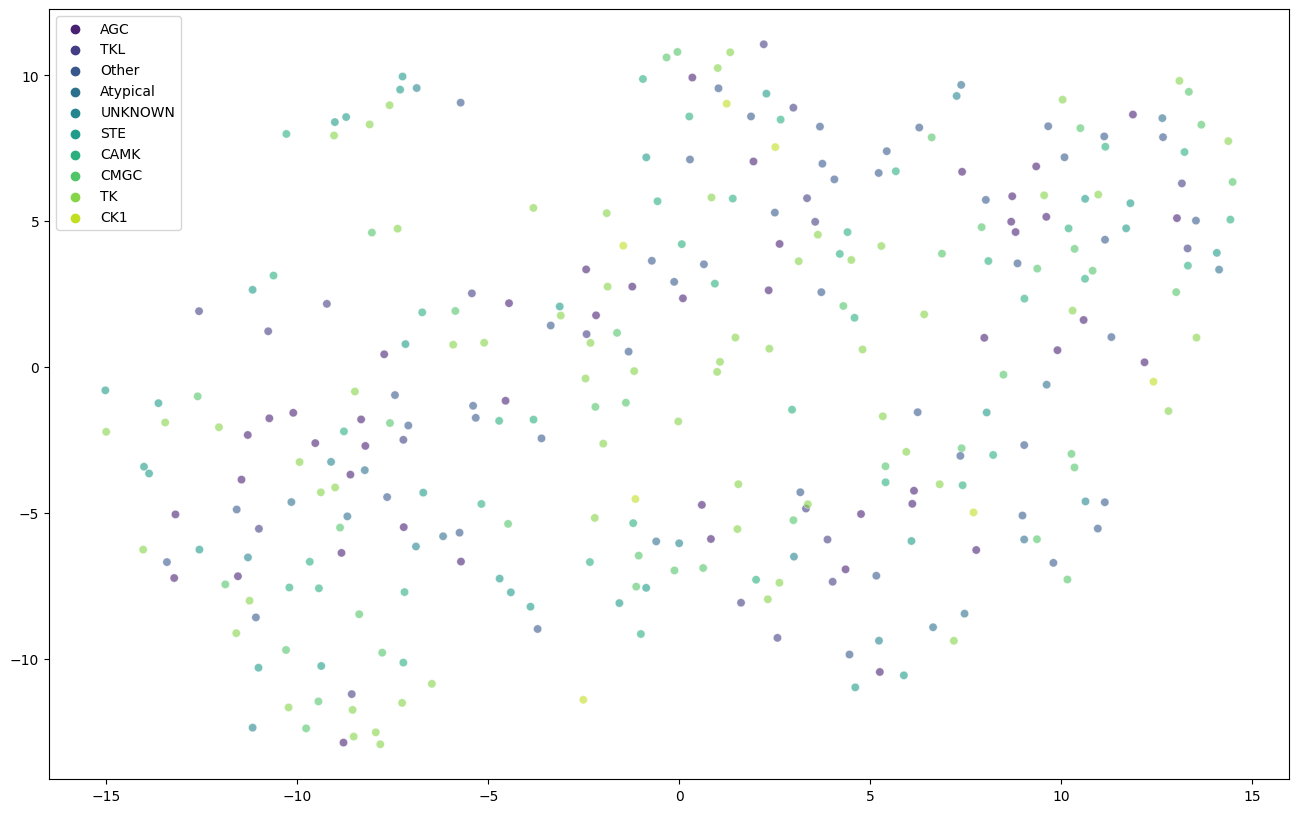

In [65]:
"""Load kinase structure embeddings (KINASE-AWARE BINARY CLASSIFIER)"""

import numpy as np
from CASM.kin_sub_pairs import get_kinase_name_dict

kin_name_dict = get_kinase_name_dict()

label_by = "Group"
#label_by = "Family"

def kin_to_family(k):
    if k in kin_name_dict:
        return kin_name_dict[k][label_by]
    return "UNKNOWN"


# MODEL 1 
fp = "./kinase_embeddings_m1_conv1_gep_23.npy"
em = np.load(fp)

kinases = []
fp = "kinase_embeddings_uniprot_list.txt"
with open(fp) as f:
    for line in f:
        x = line[:-1]
        kinases.append(x)

labels = [kin_to_family(k) for k in kinases]




# Label by family 
# labels = ["UNKNOWN"] * len(em)
plot_tsne(em, labels)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3142 samples in 0.000s...
[t-SNE] Computed neighbors for 3142 samples in 0.316s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3142
[t-SNE] Computed conditional probabilities for sample 2000 / 3142
[t-SNE] Computed conditional probabilities for sample 3000 / 3142
[t-SNE] Computed conditional probabilities for sample 3142 / 3142
[t-SNE] Mean sigma: 8.915642
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.666626
[t-SNE] KL divergence after 300 iterations: 1.209382


<AxesSubplot: >

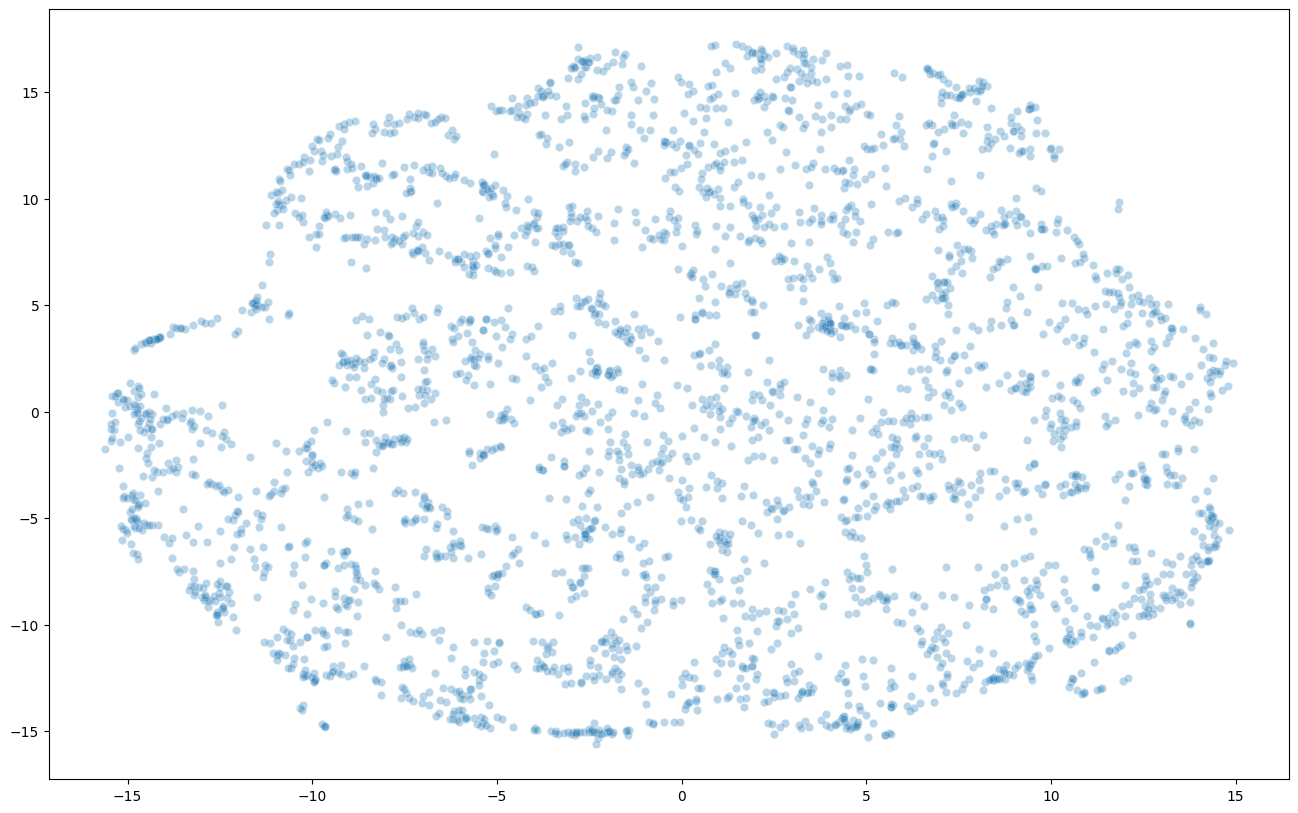

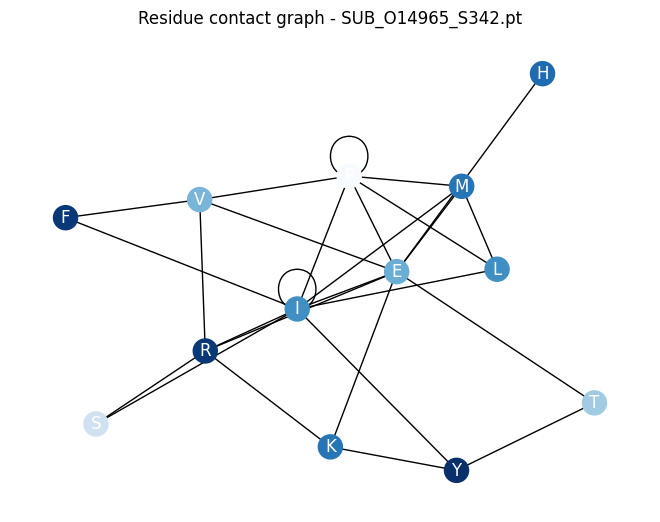

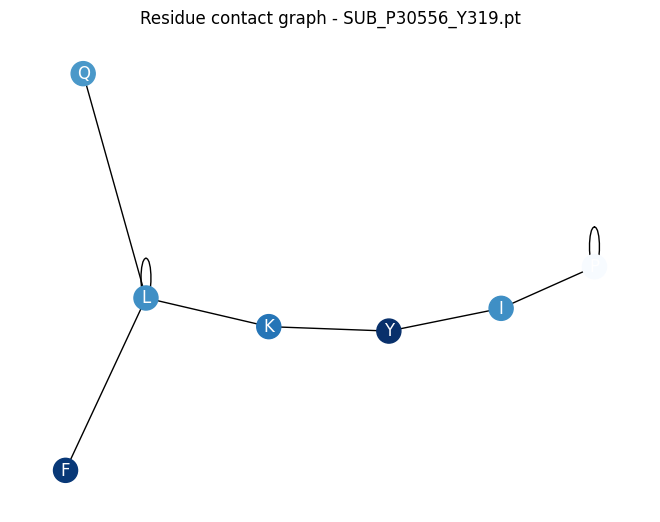

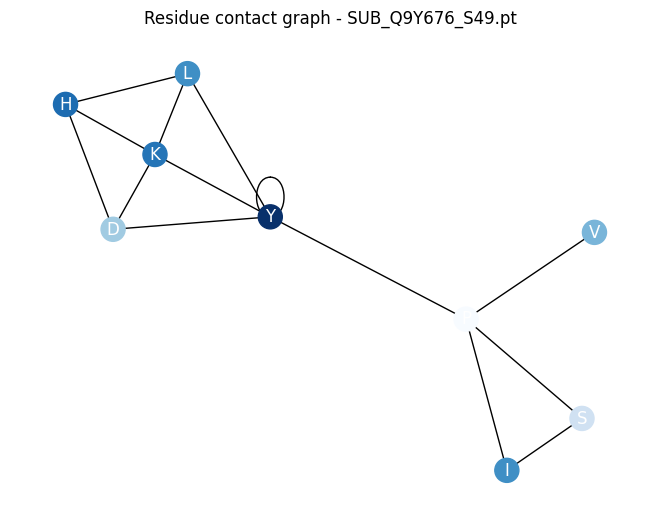

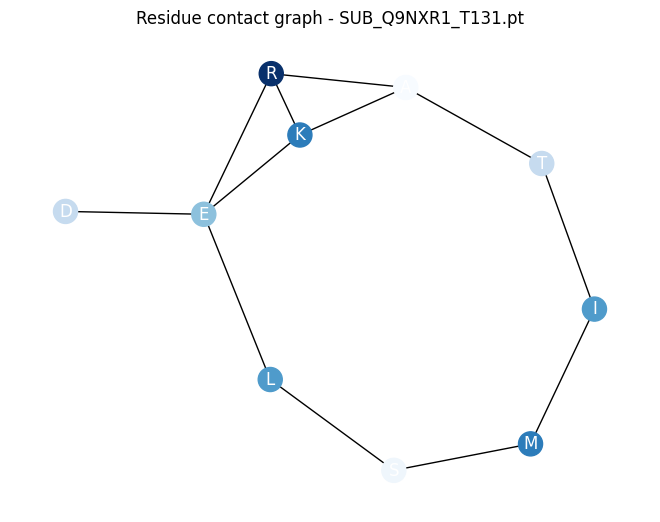

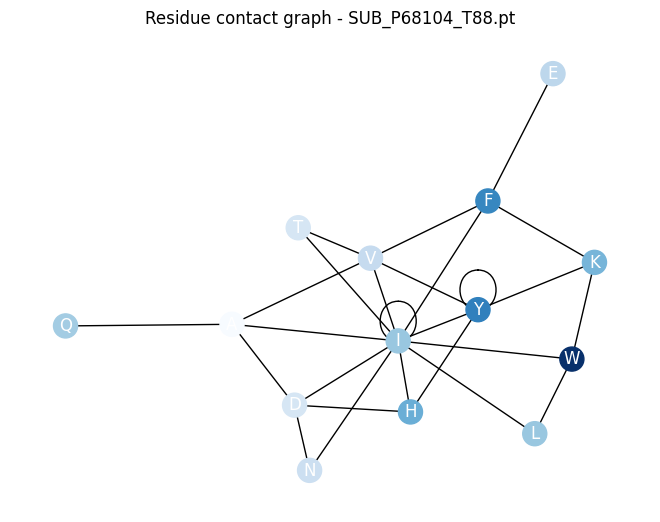

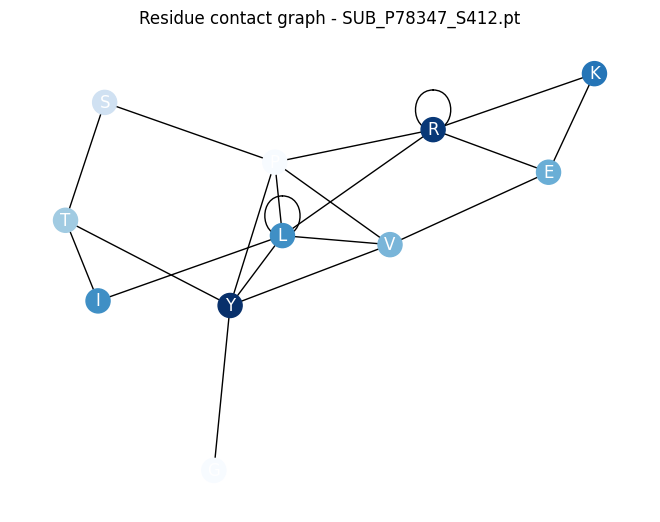

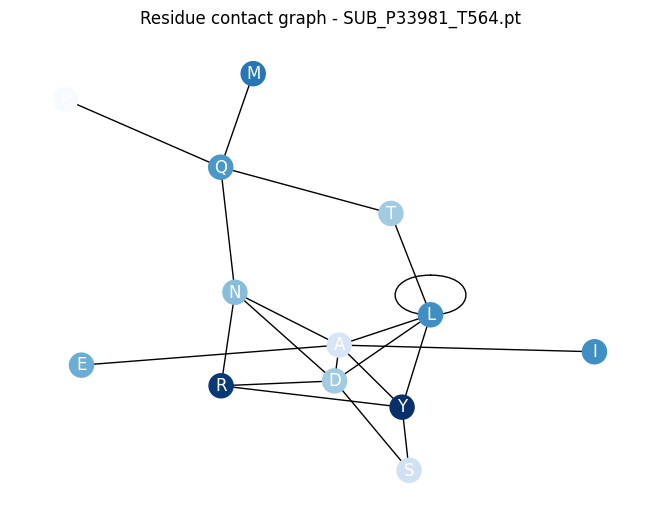

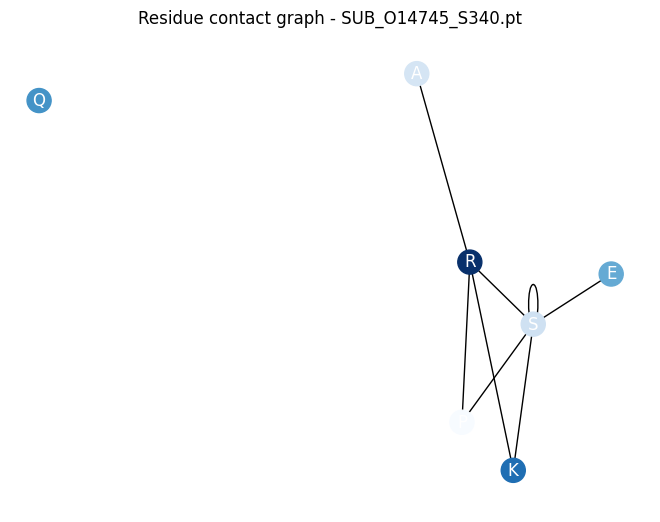

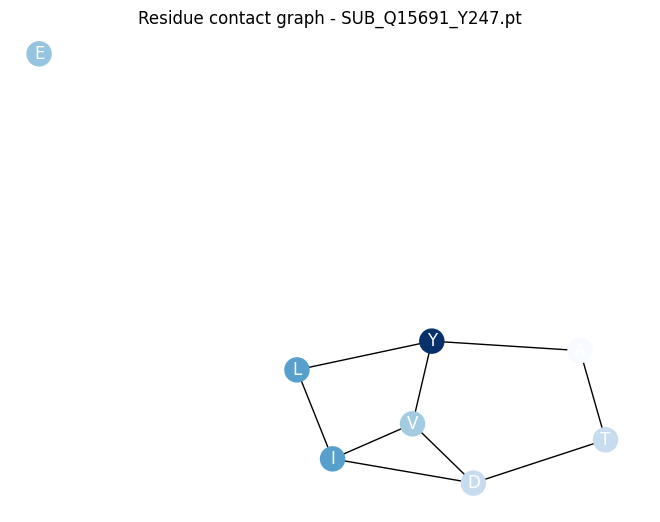

In [93]:
"""
Visualise some graphs
"""

import networkx as nx
import matplotlib.pyplot as plt
import random

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)


root_dir = "../GRAPHS1/processed/"

#data = torch_geometric.data.Data(x=x, edge_index=edge_index)
kinase_fns = glob.glob("KIN_*", root_dir=root_dir)
sub_fns = glob.glob("SUB_*", root_dir=root_dir)

plotting = "subs"
if plotting == "subs":
    to_plot = random.sample(sub_fns, 9)

elif plotting == "kins": 
    to_plot = random.sample(kinase_fns, 9)

# GRAPHS 3 
#root_dir = "../GRAPHS3_MEILER/processed/"

#fns = glob.glob("P*.pt", root_dir=root_dir)
#to_plot = random.sample(fns, 9)

from utils.residue import aa3to1, aa1to3
# Colour by:
m_dim = 1

for i, k in enumerate(to_plot):

    plt.figure(i+1)
    data = torch.load(os.path.join(root_dir, k))
    
    g = torch_geometric.utils.to_networkx(data, to_undirected=True)

    #print(data.node_index) # this hasn't been created yet by dataset loader
    
    mapping = {}
    for i in g.nodes():
        node = data.node_id[i]
        res = node.split(':')[1]
        mapping[i] = aa3to1(res)

    g = nx.relabel_nodes(g, mapping)

    def val_map(val):
        res = aa1to3(val)
        return df[res][m_dim]
         
    
    values = [val_map(node) for node in g.nodes()]
    nx.draw(g, cmap=plt.get_cmap('Blues'), node_color=values, with_labels=True, font_color="white")

    plt.title(f"Residue contact graph - {k}")



{'THR': 14.938226746480675, 'GLU': 15.513065899414656, 'GLY': 8.993971835436236, 'LEU': 14.301133785387531, 'PHE': 10.000290395424658, 'ASP': 10.537955553750466, 'ASN': 10.801196457573752, 'SER': 10.395704996112183, 'LYS': 14.553917398372807, 'TYR': 10.532319267310951, 'ARG': 12.213231119695052, 'ILE': 16.61281897564807, 'VAL': 14.788937106311637, 'HIS': 10.842486776193812, 'PRO': 17.210635644128526, 'ALA': 11.73701857016578, 'MET': 14.572514906316728, 'GLN': 14.198519457828375, 'CYS': 8.972456397313575, 'TRP': 9.683481616978957}


Text(0.5, 1.0, 'Nearest residue to predicted ATP coordinates in kinase structures')

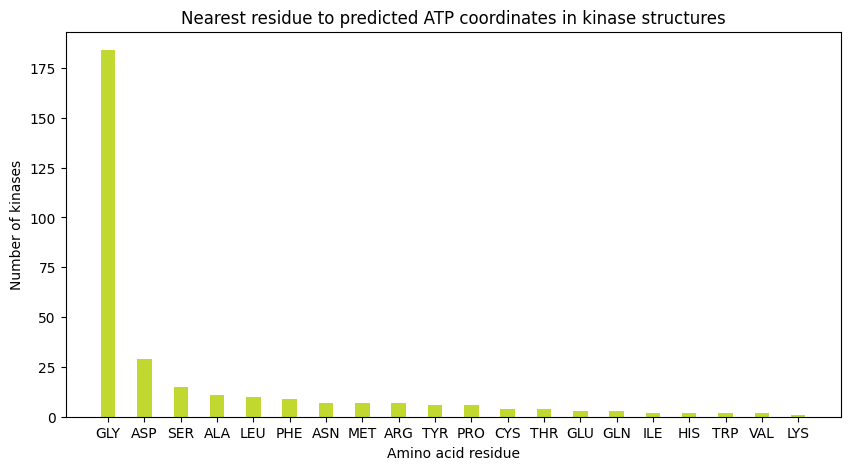

In [66]:
"""
Get nearest residue to ATP coords (Kinase structure)
"""

import networkx as nx
import matplotlib.pyplot as plt
import random

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)


root_dir = "../GRAPHS1/"

processed_dir = os.path.join(root_dir, "processed")

#data = torch_geometric.data.Data(x=x, edge_index=edge_index)
kinase_fns = glob.glob("KIN_*", root_dir=processed_dir)
kinase_fns = sorted(kinase_fns)

kin_ids = []
for k in kinase_fns:
    m = re.search(r'KIN_(.*?).pt', k)
    kin_ids.append(m.group(1))



from CASM.kin_sub_pairs import get_atp_site_dict, KIN_ATP_COORDS_RMSD

atp_site = get_atp_site_dict(KIN_ATP_COORDS_RMSD)
# for k in kin_ids[0:10]:
#     print(atp_site[k])

#to_plot = random.sample(sub_fns, 9)

# GRAPHS 3 
#root_dir = "../GRAPHS3_MEILER/processed/"

#fns = glob.glob("P*.pt", root_dir=root_dir)
#to_plot = random.sample(fns, 9)

from utils.residue import aa3to1, aa1to3

count = {}
avg_distance = {}
for i, k in enumerate(kin_ids[0:999]):
    
  
    k_fn = kinase_fns[i]

    data = torch.load(os.path.join(processed_dir, k_fn))
    
    # Find closest residue to ATP binding site 
    (x, y, z) = atp_site[k]['coords']


    x, y, z = float(x), float(y), float(z)
    a = np.array([x, y, z])
    #print((x, y, z), )

    coords = data.coords[0]
    distances = np.zeros(len(coords))
    for i, c in enumerate(coords):
        b = np.array(c)
        distance = np.linalg.norm(a-b)
        distances[i] = distance
        
        node = data.node_id[i]
        res = node.split(':')[1]
        if res not in avg_distance:
            avg_distance[res] = []

        avg_distance[res].append(distance)

    # Get index of smallest distance 
    idx = np.argmin(distances)
    node = data.node_id[idx]
    #print(node)

    # Count residue occurence
    res = node.split(':')[1]
    
    if res not in count:
        count[res] = 0
    count[res] += 1

    
    #print(data.coords)

    fp = os.path.join(processed_dir, k_fn)

actual_avg_distance = {}
for key, val in avg_distance.items():

    
    actual_avg_distance[key] = sum(val) / len(val)

print(actual_avg_distance)

#count = actual_avg_distance

#for i, c in count.items(): print(i, c)

# Plot 
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = (10, 5))

counts = count.items()
counts = sorted(counts, key=lambda x: x[1], reverse=True)

count = dict(counts)

plt.bar(
    count.keys(),
    count.values(),
    color="#C1D831", width=0.4)
    
plt.xlabel("Amino acid residue")
plt.ylabel("Number of kinases")
plt.title("Nearest residue to predicted ATP coordinates in kinase structures")
